In [3]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn import linear_model
import scipy.stats as st
import numpy as np
import plotly.figure_factory as ff


data_a = pd.read_csv("election_train.csv")
data_b = pd.read_csv("demographics_train.csv")

data_a_tidy = pd.pivot_table(data_a,index = ['Year','State','County','Office'],columns = 'Party',values = 'Votes', aggfunc='sum').reset_index()

print(data_a_tidy.head())


Party  Year State           County      Office  Democratic  Republican
0      2018    AZ    Apache County  US Senator     16298.0      7810.0
1      2018    AZ   Cochise County  US Senator     17383.0     26929.0
2      2018    AZ  Coconino County  US Senator     34240.0     19249.0
3      2018    AZ      Gila County  US Senator      7643.0     12180.0
4      2018    AZ    Graham County  US Senator      3368.0      6870.0


In [4]:
data_a_tidy['County'] = data_a_tidy['County'].str.replace(' County','')
data_a_tidy['County'] = data_a_tidy['County'].str.lower()
data_b['County'] = data_b['County'].str.lower()

change_state = {'Arizona' : 'AZ', 'Connecticut' : 'CT', 'Delaware' : 'DE', 'Florida' : 'FL', 'Hawaii' : 'HI', 'Indiana' : 'IN', 'Maine' : 'ME', 'Maryland' : 'MD', 'Massachusetts' : 'MA', 'Michigan' : 'MI', 'Minnesota' : 'MN', 'Montana' : 'MT', 'Nebraska' : 'NE', 'Nevada' : 'NV', 'New Jersey' : 'NJ', 'New Mexico' : 'NM', 'New York' : 'NY', 'North Dakota' : 'ND', 'Ohio' : 'OH', 'Pennsylvania' : 'PA', 'Rhode Island' : 'RI', 'Tennessee' : 'TN', 'Texas' : 'TX', 'Utah' : 'UT', 'Vermont' : 'VT', 'Virginia' : 'VA', 'Washington' : 'WA', 'West Virginia' : 'WV', 'Wisconsin' : 'WI', 'Wyoming' : 'WY'}
data_b['State'] = data_b['State'].map(change_state)

data_merge = pd.merge(data_a_tidy,data_b, how="inner", on=['County','State'], sort=True)
print(data_merge.head())


   Year State County      Office  Democratic  Republican   FIPS  \
0  2018    IN  adams  US Senator      3146.0      7511.0  18001   
1  2018    ND  adams  US Senator       364.0       796.0  38001   
2  2018    NE  adams  US Senator      3334.0      6487.0  31001   
3  2018    OH  adams  US Senator      2635.0      6000.0  39001   
4  2018    PA  adams  US Senator     14880.0     23419.0  42001   

   Total Population  Citizen Voting-Age Population  \
0             34813                              0   
1              2348                              0   
2             31536                              0   
3             28111                              0   
4            101759                          78370   

   Percent White, not Hispanic or Latino  ...  Percent Hispanic or Latino  \
0                              93.740844  ...                    4.403527   
1                              93.100511  ...                    0.851789   
2                              87.338280 

In [5]:
data_merge.info()
print(data_merge.info())
print(data_merge.Year.unique())
print(data_merge.Office.unique())
data_merge = data_merge.drop(columns=['Office','Year'])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1200 entries, 0 to 1199
Data columns (total 21 columns):
Year                                     1200 non-null int64
State                                    1200 non-null object
County                                   1200 non-null object
Office                                   1200 non-null object
Democratic                               1200 non-null float64
Republican                               1200 non-null float64
FIPS                                     1200 non-null int64
Total Population                         1200 non-null int64
Citizen Voting-Age Population            1200 non-null int64
Percent White, not Hispanic or Latino    1200 non-null float64
Percent Black, not Hispanic or Latino    1200 non-null float64
Percent Hispanic or Latino               1200 non-null float64
Percent Foreign Born                     1200 non-null float64
Percent Female                           1200 non-null float64
Percent Age 29 and Und

In [6]:
print(data_merge.isnull())

print(data_merge.isin([0]).sum())
print(data_merge.isin([0]).sum().sum())

# Drop 'Citizen Voting-Age Population' due to too many missing values
data_merge = data_merge.drop(columns='Citizen Voting-Age Population')

# Replaces 0s with NaN for interpolate to be used for other columns because not many are missing
data_merge = data_merge.replace(0, np.nan)
data_merge = data_merge.interpolate(method='linear')

# Shows no more 0s
print(data_merge.isin([0]).sum())


      State  County  Democratic  Republican   FIPS  Total Population  \
0     False   False       False       False  False             False   
1     False   False       False       False  False             False   
2     False   False       False       False  False             False   
3     False   False       False       False  False             False   
4     False   False       False       False  False             False   
...     ...     ...         ...         ...    ...               ...   
1195  False   False       False       False  False             False   
1196  False   False       False       False  False             False   
1197  False   False       False       False  False             False   
1198  False   False       False       False  False             False   
1199  False   False       False       False  False             False   

      Citizen Voting-Age Population  Percent White, not Hispanic or Latino  \
0                             False                      

In [7]:
def func(row) :
    if row['Democratic'] > row['Republican']:
        val = 1
    else:
        val = 0
    return val

data_merge['Party'] = data_merge.apply(func, axis = 1)
print(data_merge.head())


  State County  Democratic  Republican   FIPS  Total Population  \
0    IN  adams      3146.0      7511.0  18001             34813   
1    ND  adams       364.0       796.0  38001              2348   
2    NE  adams      3334.0      6487.0  31001             31536   
3    OH  adams      2635.0      6000.0  39001             28111   
4    PA  adams     14880.0     23419.0  42001            101759   

   Percent White, not Hispanic or Latino  \
0                              93.740844   
1                              93.100511   
2                              87.338280   
3                              96.673900   
4                              89.762085   

   Percent Black, not Hispanic or Latino  Percent Hispanic or Latino  \
0                               0.709505                    4.403527   
1                               0.894378                    0.851789   
2                               0.821284                    8.907281   
3                               0.355733    

In [8]:
data_merge.groupby('Party', as_index = False)['Total Population'].mean()

# // ( perform the hypothesis testing) //
democratic = data_merge[data_merge['Party'] == 1]
republican = data_merge[data_merge['Party'] == 0]

[statistic, pvalue] = st.ttest_ind(democratic['Total Population'],republican['Total Population'], equal_var= False)


In [9]:
data_merge.groupby('Party', as_index = False)['Median Household Income'].mean()

# // ( perform the hypothesis testing) //
[statistic, pvalue] = st.ttest_ind(democratic['Median Household Income'],republican['Median Household Income'], equal_var= False)


Democratic                                7969.218286
Republican                               12685.142286
FIPS                                     38755.305143
Total Population                         53974.214857
Percent White, not Hispanic or Latino       82.597026
Percent Black, not Hispanic or Latino        4.454970
Percent Hispanic or Latino                   9.847969
Percent Foreign Born                         4.017041
Percent Female                              49.617156
Percent Age 29 and Under                    36.020984
Percent Age 65 and Older                    18.814997
Median Household Income                  48724.150857
Percent Unemployed                           6.425490
Percent Less than High School Degree        14.029195
Percent Less than Bachelor's Degree         81.103128
Percent Rural                               63.431458
Party                                        0.000000
dtype: float64
 
Democratic                                71193.172308
Republican

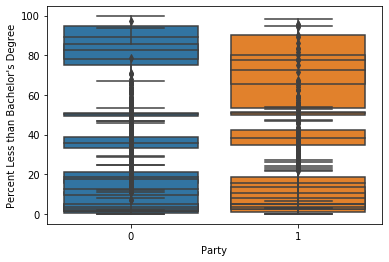

In [10]:
data_merge['Party'].value_counts(normalize=True)

#Printing out the averages for each party
print(data_merge[data_merge['Party']==0].mean())
print(" ")

print(data_merge[data_merge['Party']==1].mean())


sns.boxplot(x='Party', y='Percent Age 29 and Under', data=data_merge)

sns.boxplot(x='Party', y='Percent Age 65 and Older', data=data_merge)

sns.boxplot(x='Party', y='Percent Female', data=data_merge)

sns.boxplot(x='Party', y='Percent White, not Hispanic or Latino', data=data_merge)

sns.boxplot(x='Party', y='Percent Black, not Hispanic or Latino', data=data_merge)

sns.boxplot(x='Party', y='Percent Hispanic or Latino', data=data_merge)

sns.boxplot(x='Party', y='Percent Foreign Born', data=data_merge)

sns.boxplot(x='Party', y='Percent Less than High School Degree', data=data_merge)

sns.boxplot(x='Party', y="Percent Less than Bachelor's Degree", data=data_merge)


In [11]:
#Task 10-1 Democratic Counties
fips = democratic['FIPS']
values = range(len(fips))

fig = ff.create_choropleth(fips=fips, values=values)
fig.layout.template = None
fig.show()



#Task 10-2-Republican Counties
fips = republican['FIPS']
values = range(len(fips))

fig = ff.create_choropleth(fips=fips, values=values)
fig.layout.template = None
fig.show()


ImportError: geopandas, pyshp and shapely must be installed for this figure factory.

Run the following commands to install the correct versions of the following modules:

```
$ pip install geopandas==0.3.0
$ pip install pyshp==1.2.10
$ pip install shapely==1.6.3
```
If you are using Windows, follow this post to properly install geopandas and dependencies:http://geoffboeing.com/2014/09/using-geopandas-windows/

If you are using Anaconda, do not use PIP to install the packages above. Instead use conda to install them:

```
$ conda install plotly
$ conda install geopandas
```